[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/isacki/ai3project/blob/master/explore_nans.ipynb)

To open this file in Colab, click the link above. You might have to authorize Colab to access your private GitHub repositories. This can be done with the following steps:

1. Navigate to http://colab.research.google.com/github.
2. Click the "Include Private Repos" checkbox.
3. In the popup window, sign-in to your Github account and authorize Colab to read the private files.

# Import modules and data

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import os

Download fixed data from a shared folder so that we all use the same data.

In [11]:
# Download data
import gdown
work_dir = os.path.abspath("/content")
work_file = os.path.join(work_dir, "owid-covid-data.csv")
data_file_link = "https://drive.google.com/uc?id=1zWIKCrWWeEGjEe5Q88i21Lu9Cet_TzdQ"
gdown.download(data_file_link, work_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zWIKCrWWeEGjEe5Q88i21Lu9Cet_TzdQ
To: /content/owid-covid-data.csv
5.71MB [00:00, 104MB/s]


'/content/owid-covid-data.csv'

In [12]:
infname = "owid-covid-data.csv"
indata = pd.read_csv(infname)

Basic information about the dataset:

In [13]:
print("Shape of original data: " + str(indata.shape))
print("Columns of original data: ")
print(indata.columns)

Shape of original data: (31705, 34)
Columns of original data: 
Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy'],
      dtype='object')


It's probably useful to break the columns up into columns that measure the effects of COVID-19 (such as number of deaths/cases) from those that measure the others factors which might predict the effects of COVID-19. We also from remove 'location' and 'date' from the list of factors.

In [14]:
effects = ["total_cases", "new_cases", "total_deaths", "new_deaths",
          "total_cases_per_million", "new_cases_per_million",
          "total_deaths_per_million", "new_deaths_per_million"]
factors = [col for col in indata.columns if col not in effects]
for factor in ("location", "date"):
    factors.remove(factor)
print("Remaining factors: ")
print(factors)

Remaining factors: 
['iso_code', 'continent', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy']


One interesting column is the 'tests_units' column. It consists of these unique entries:

In [15]:
indata["tests_units"].drop_duplicates()

0                                  NaN
1053                   tests performed
2269                     units unclear
2408                    samples tested
5304                     people tested
14960    people tested (incl. non-PCR)
30025    units unclear (incl. non-PCR)
Name: tests_units, dtype: object

We'll certainly have to drop it eventually but we'll probably have to think about how to use it to correct the tests columns given to us.

In [16]:
print("Number of locations: {:d}".format(indata["location"].drop_duplicates().dropna().count()))
print("Number of dates: {:d}".format(indata["date"].drop_duplicates().dropna().count()))
print("Number of continents: {:d}".format(indata["continent"].drop_duplicates().dropna().count()))

Number of locations: 212
Number of dates: 204
Number of continents: 6


In [17]:
indata["date"] = pd.to_datetime(indata["date"], format="%Y-%m-%d")
multi_indexed_data = indata.set_index(["date", "location"])
dates = indata["date"].drop_duplicates()
locations = indata["location"].drop_duplicates()

## Explore NaN values in the original dataset

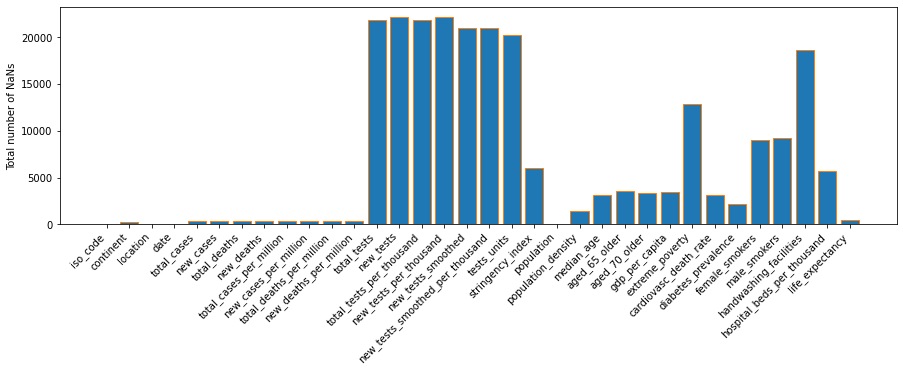

In [18]:
nans_in_cols = np.sum(indata.isna())
plt.figure(figsize=(15,4))
plt.ylabel("Total number of NaNs")
plt.xticks(np.arange(len(indata.columns)), indata.columns.to_numpy(),
          rotation=45, ha="right")
plt.bar(np.arange(len(indata.columns)), nans_in_cols, edgecolor="C1")
plt.show()

It seems that there about 13 columns with a large number of NaN values.
For convenience, we print out the 13 columns with the largest numbers of NaN values.

In [19]:
nans_in_cols.sort_values(ascending=False)[:13]

new_tests                          22146
new_tests_per_thousand             22146
total_tests_per_thousand           21867
total_tests                        21867
new_tests_smoothed_per_thousand    21015
new_tests_smoothed                 21015
tests_units                        20257
handwashing_facilities             18677
extreme_poverty                    12841
male_smokers                        9251
female_smokers                      8981
stringency_index                    6004
hospital_beds_per_thousand          5697
dtype: int64

## Plot the total number of NaNs (for all locations and columns) as a function of time

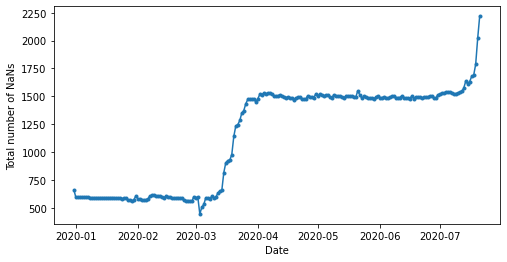

In [20]:
timed_grp = multi_indexed_data.isna().sum(axis=1).groupby(level="date")
na_time = timed_grp.sum()

plt.figure(figsize=(8,4))
plt.xlabel("Date")
plt.ylabel("Total number of NaNs")
plt.plot_date(mdate.date2num(na_time.index), na_time, ".-")
plt.show()

It seems a little strange that the total number of NaNs is increasing as a function of time since we would expect there to be more data coming in as the pandemic progresses and more locations start to report their numbers. However, we can understand parts of the plot above by examining, for each location, the time periods over which we have *any* data. 

We plot below, for each location, the time period over which we have *any* data. The colored bars below denote the time period over which there **is** *some* data. Plotted right underneath it is the same plot as above. The dashed orange vertical lines running through both plots demarcate the transition from one plateau to another. From the plot below, we can at least understand the transition to the middle plateau as due to more countries starting to report their incomplete data, which results in an overall increase in the total number of NaNs. 

However, the increase at the end (late July), is not quite explained by the plot below since there isn't a significant change in the number of reporting countries by that time.

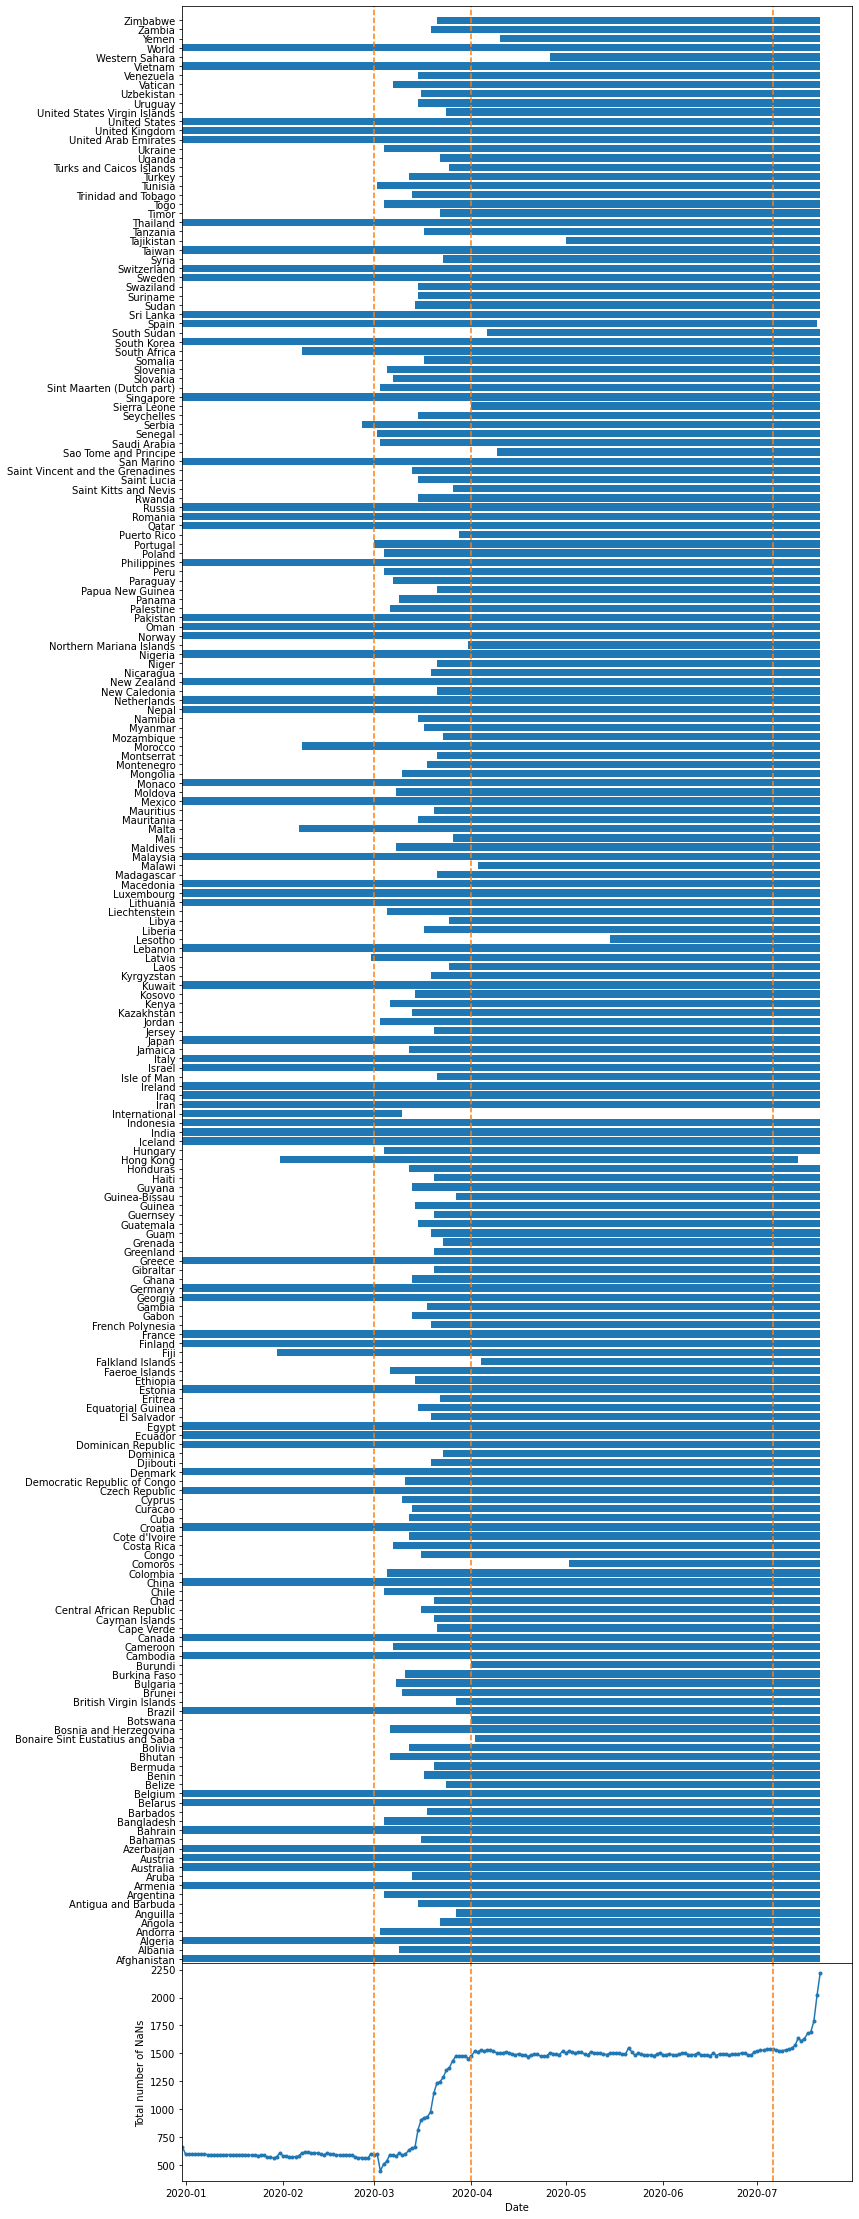

In [21]:
left = indata[["date", "location"]].groupby("location")["date"].min()
right = indata[["date", "location"]].groupby("location")["date"].max()
tdiff = right - left
width = tdiff.to_numpy()/np.timedelta64(1, "D")

fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(12,40), sharex=True,
                             gridspec_kw={"height_ratios": [9,1],
                                         "hspace": 0})
vlines = [np.datetime64("2020-03-01", "D"), np.datetime64("2020-04-01", "D"),
          np.datetime64("2020-07-06", "D")]

formatter = mdate.DateFormatter("%Y-%m-%d")
locator = mdate.MonthLocator()

ax1.xaxis.set_major_formatter(formatter)
ax1.xaxis.set_major_locator(locator)
ax1.barh(np.arange(left.shape[0]), width, left=mdate.date2num(left),
         tick_label=list(left.index))
for vline in vlines:
    ax1.axvline(x=mdate.date2num(vline), color="C1", ls="--")
ax1.set_ylim((-0.5,left.shape[0]+0.5))
ax2.set_xlabel("Date")
ax2.set_ylabel("Total number of NaNs")
ax2.plot_date(mdate.date2num(na_time.index), na_time, ".-")
for vline in vlines:
    ax2.axvline(x=mdate.date2num(vline), color="C1", ls="--")
plt.show()

## Plot the total number of NaNs (over all locations) in each column as a function of time

In [22]:
date_indexed_data = indata.set_index("date")
columns = list(date_indexed_data.columns)

@interact
def plot_na_vs_time(slider=(0,len(columns)-1),
                    Column=columns,
                    use_slider=[True,False],
                    indata=widgets.fixed(date_indexed_data)):
    columns = indata.columns
    if use_slider:
        column = columns[slider]
    else:
        column = Column
    
    grp = indata[column].isna().groupby("date")
    ydf = grp.sum()
    
    plt.figure(figsize=(8,4))
    plt.xlabel("Date")
    plt.ylabel("Number of NaNs")
    plt.title("NaNs in " + column)
    plt.plot_date(mdate.date2num(ydf.index), ydf, ".-")
    plt.show()

interactive(children=(IntSlider(value=16, description='slider', max=32), Dropdown(description='Column', option…

It's interesting to note that for the top 13 columns with the most number of NaNs values (reproduced here for convenience),

new_tests                          22146
new_tests_per_thousand             22146
total_tests_per_thousand           21867
total_tests                        21867
new_tests_smoothed_per_thousand    21015
new_tests_smoothed                 21015
tests_units                        20257
handwashing_facilities             18677
extreme_poverty                    12841
male_smokers                        9251
female_smokers                      8981
stringency_index                    6004
hospital_beds_per_thousand          5697,

they all follow the same profile as the total number of NaNs over all locations and columns. In particular, they all exhibit at least two plateaus, which suggests from our explanation above, that this increase is primarily due to a lot of other countries starting to report their (incomplete) data, many of which did not contain the data listed above. This is in contrast to some other data such as total_deaths, total_cases, new_cases, etc, which almost every country seem to have reported during the April to June period. **This means that we will have a lot more countries where we see the effects of COVID-19 (such as deaths, new cases, etc.) but have little other information about the number of tests, handwashing facitilies, and other data categories listed in the list above. We might therefore have to leave these countries out during the April to June time period when trying to ascertain the effect of these variables on the deaths.**

It also turns out that the NaNs for 'iso_code' and 'continent' are due to the 'world' and 'international' locations as the cell below demonstrates. What exactly is an 'international' location?

In [23]:
print("Locations with NaN iso_code:")
print(indata.loc[indata["iso_code"].isna()]["location"].drop_duplicates())
print("\nLocations with NaN continent:")
print(indata.loc[indata["continent"].isna()]["location"].drop_duplicates())

Locations with NaN iso_code:
31641    International
Name: location, dtype: object

Locations with NaN continent:
31437            World
31641    International
Name: location, dtype: object


## Examine, for each location, the availability and consistency of data collected

One way to do this is to calculate the mean and standard deviation of the number of NaNs in all of the columns over the entire data set. Ideally, we would prefer locations that have a small mean number of NaNs, which implies that data is available for most of the columns over the entire data set. In addition, we would like a small standard deviation since that implies data was consistently collected for that particular location. We plot this information below.

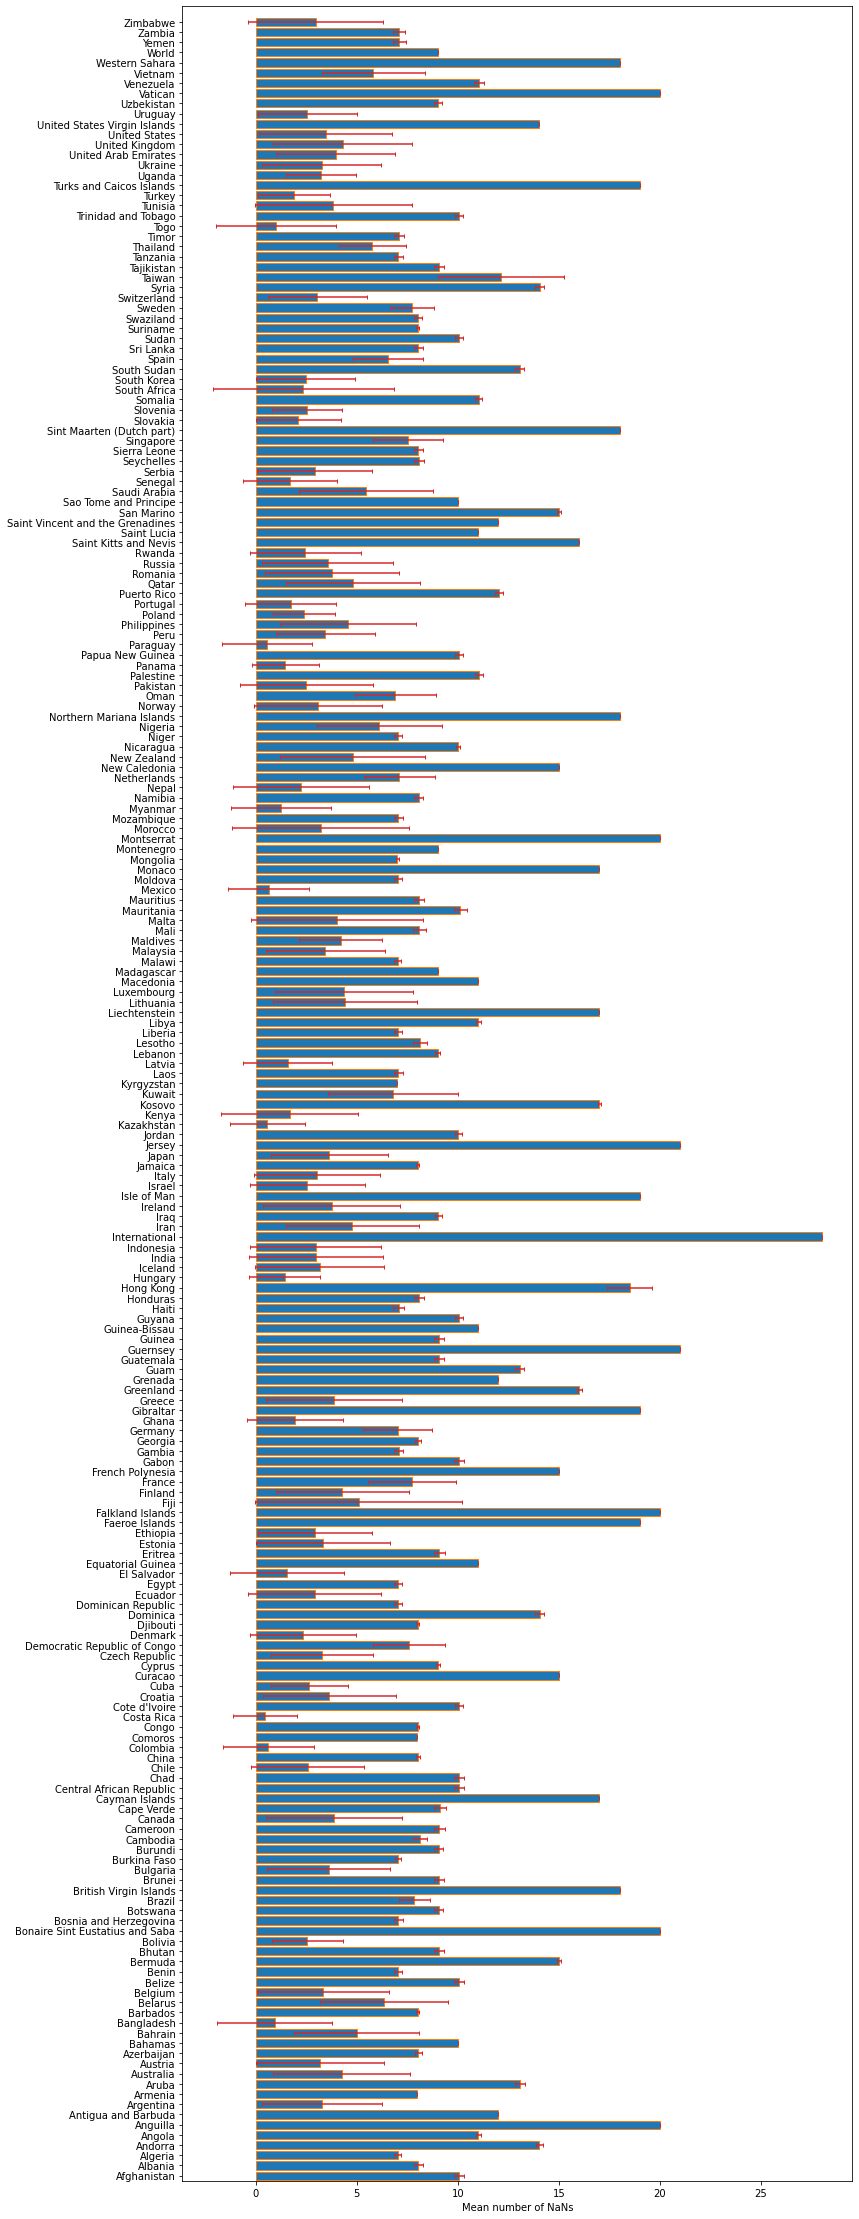

In [24]:
loc_na_grp = multi_indexed_data.isna().sum(axis=1).groupby("location")
avg_nans = loc_na_grp.mean()

plt.figure(figsize=(12,40))
plt.xlabel("Mean number of NaNs")
plt.ylim((-0.5,len(locations)+0.5))
plt.barh(np.arange(len(locations)), avg_nans, tick_label=list(avg_nans.index),
        xerr=loc_na_grp.std(), edgecolor="C1", capsize=2, ecolor="C3")
plt.show()

It is interesting to note that there are some locations with very small standard deviations. This might imply that there are columns that are consistently NaNs for those locations, which will affect how we decide to drop the NaNs.

Note from the above that the 'international' location has a very high number of NaNs consistently (zero standard deviation). The columns with NaNs for the 'international' location are:

In [25]:
np.any(multi_indexed_data.loc[(slice(None),"International"),:].isna(),
      axis=0)

iso_code                            True
continent                           True
total_cases                        False
new_cases                          False
total_deaths                       False
new_deaths                         False
total_cases_per_million             True
new_cases_per_million               True
total_deaths_per_million            True
new_deaths_per_million              True
total_tests                         True
new_tests                           True
total_tests_per_thousand            True
new_tests_per_thousand              True
new_tests_smoothed                  True
new_tests_smoothed_per_thousand     True
tests_units                         True
stringency_index                    True
population                          True
population_density                  True
median_age                          True
aged_65_older                       True
aged_70_older                       True
gdp_per_capita                      True
extreme_poverty 

Evidently, the 'international' location only has data measuring the effects of COVID-19 (total_cases, new_cases, total_deaths, and new_deaths) but no data of potential causes. **We should therefore drop all 'international' location data.**

We can examine the number of NaNs (over all columns) for each location as a function of time in a little more detail in the widget below.

In [26]:
date_min, date_max = dates.min(), dates.max()
nan_min, nan_max = np.min(loc_na_grp.min()), np.max(loc_na_grp.max())

@interact
def plot_na_by_location(slider=(0,len(locations)-1),
                        Location=list(loc_na_grp.groups.keys()),
                        use_slider=[True,False],
                       indata=widgets.fixed(loc_na_grp),
                       xlims=widgets.fixed((date_min, date_max)),
                       ylims=widgets.fixed((nan_min, nan_max))):
    locations = list(indata.groups.keys())
    if use_slider:
        location = locations[slider]
    else:
        location = Location
    
    grp = indata.get_group(location)
    t = grp.index.droplevel("location")
    
    plt.figure(figsize=(12,4))
    plt.title("Number of NaNs in " + location)
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("Date")
    plt.ylabel("Number of NaNs")
    plt.plot_date(mdate.date2num(t), grp.to_numpy(), ".-")
    plt.show()

interactive(children=(IntSlider(value=105, description='slider', max=211), Dropdown(description='Location', op…

By sliding through the various locations above, it seems that most locations see an up-tick in the number of NaNs during late July. This would correspond to and explain the increase in total number of NaNs that we saw above during late July. It's probable that this increase in NaNs during late July is due to a delay in reporting by many locations. **We should therefore probably cut out this data for now until more up-to-date information comes in.**

It is also interesting to note that many of the locations show a *decrease* in the total number of NaNs from around May to June compared to the January to May (if data existed then). I suppose a plausible reason could be governments around the world starting to up their reporting game around May.

We can also drop locations that only have effects of COVID-19 but no factors but it turns out that only 'International' does not have any valid factor columns.

In [27]:
locs_no_factors = np.all(
    multi_indexed_data[factors].isna().groupby("location").agg(
        np.all, axis=0), axis=1)
locs_no_factors.index[locs_no_factors]

Index(['International'], dtype='object', name='location')

In [ ]:
multi_indexed_data.columns

Index(['iso_code', 'continent', 'total_cases', 'new_cases', 'total_deaths',
       'new_deaths', 'total_cases_per_million', 'new_cases_per_million',
       'total_deaths_per_million', 'new_deaths_per_million', 'total_tests',
       'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy'],
      dtype='object')

## Naive attempt to drop data
1. Drop all effects except one. 
2. Drop the 'test_units' column.
3. Naively drop all rows with at least one NaN in it.
4. Print to see the remaining locations.

In [28]:
dropped_data = multi_indexed_data.drop(
    columns=[eff for eff in effects if eff!="new_cases_per_million"])
dropped_data.drop(columns="tests_units", inplace=True)
dropped_data.dropna(inplace=True)
print("Available dates for each location: ")
print(dropped_data["new_cases_per_million"].groupby("location").count())

Available dates for each location: 
location
Bangladesh      122
Colombia        123
Costa Rica      118
Ecuador         100
El Salvador      93
Ethiopia         49
Ghana            68
India           101
Indonesia        98
Kazakhstan      112
Kenya            92
Mexico          182
Myanmar          89
Nepal           127
Pakistan        117
Paraguay        127
South Africa    120
Togo            119
Tunisia          65
Vietnam          20
Zimbabwe         64
Name: new_cases_per_million, dtype: int64


Is this good enough? I'm a little skeptical because many of the locations in the list above might not give us representative data from the 'hot-spots' around the world. If this is not good enough, we might have to narrow down the list of factors that we would like to consider.

May be we can use this group to conduct feature selection that we will enable us to further narrow down the list of factors to consider? 

We also need to more sharply define what we're trying to predict. For example, is the model trying to accompolish: given x past days of data, it can predict the new_cases_per_million y days into the future? If so, how would we decide on x and y? 